In [358]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.utils.data import TensorDataset
from tqdm import trange

import torch.nn.functional as F
from tqdm import trange


Available datasets: ['delta_psi_maps', 'images_clean', 'images_rgb', 'is_detectable', 'residual_l2_null', 'residual_l2_sub', 'sel_idx', 'snr_proxy', 'source_x', 'source_y', 'subhalo_mass', 'subhalo_x', 'subhalo_y', 'y_hat']
images_rgb         -> shape (7564, 40, 40, 3), dtype float32
images_clean       -> shape (7564, 40, 40, 3), dtype float32
delta_psi_maps     -> shape (7564, 40, 40), dtype float32
residual_l2_sub    -> shape (7564, 40, 40), dtype float32
residual_l2_null   -> shape (7564, 40, 40), dtype float32
subhalo_mass       -> shape (7564,), dtype float32
subhalo_x          -> shape (7564,), dtype float32
subhalo_y          -> shape (7564,), dtype float32
source_x           -> shape (7564,), dtype float32
source_y           -> shape (7564,), dtype float32
snr_proxy          -> shape (7564,), dtype float32
is_detectable      -> shape (7564,), dtype int8

Attributes:
 - H0_Om0_Ob0: [7.0e+01 3.0e-01 4.8e-02]
 - N_samples: 7564
 - bands: g,r,i
 - clf_name: SimpleCNN
 - clf_thresho

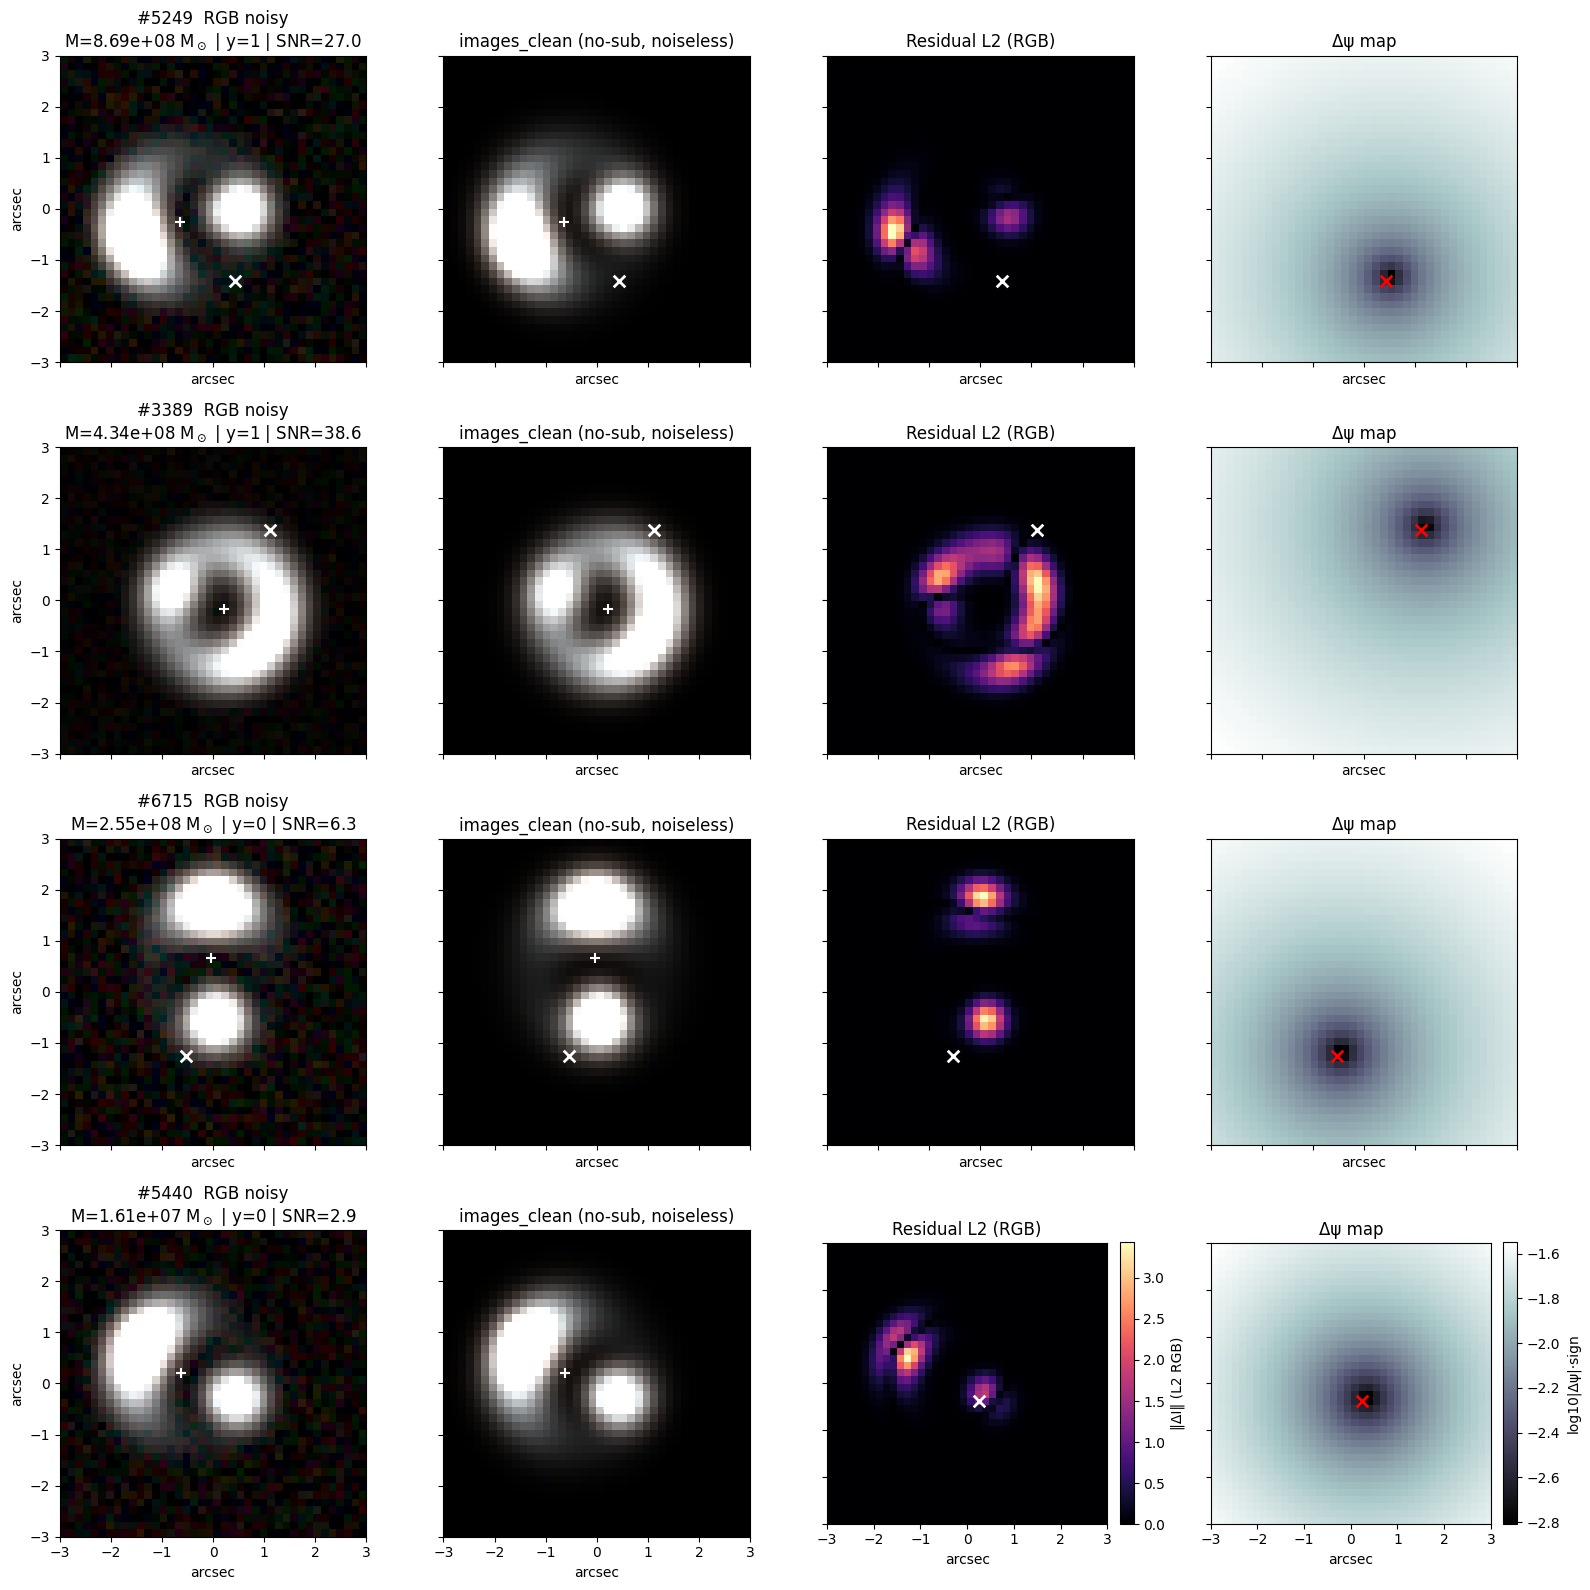

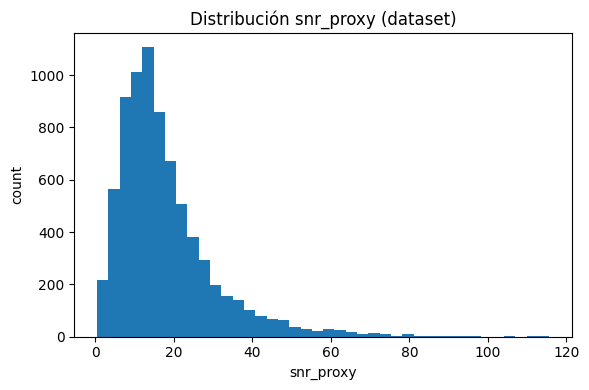


Fracción detectable = 0.735


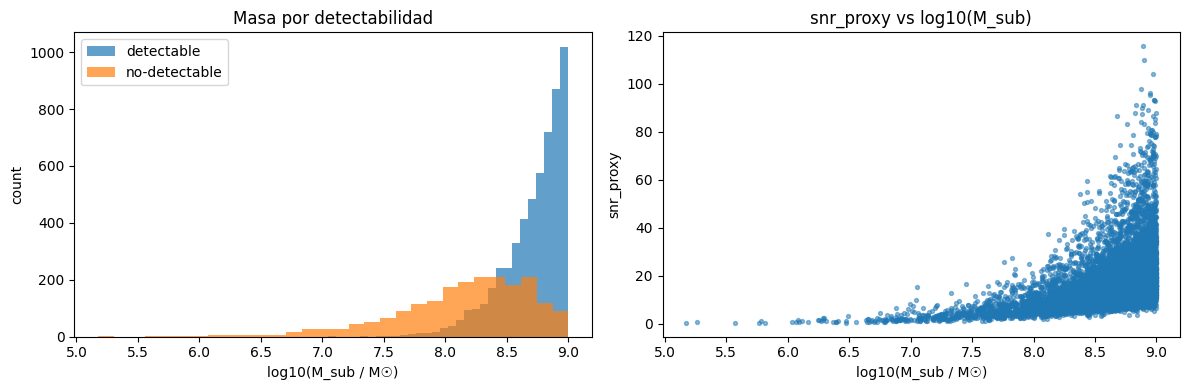

In [359]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

# ---------------------------
# Utils
# ---------------------------
def _get_extent(f):
    """extent=[xmin,xmax,ymin,ymax] en arcsec para imshow."""
    ny, nx = f['images_rgb'].shape[1:3]
    if 'stamp_size_arcsec' in f.attrs:
        L = float(f.attrs['stamp_size_arcsec'])
        return [-L/2, L/2, -L/2, L/2]
    ps = float(f.attrs.get('pixel_scale_arcsec', 0.15))
    return [-nx*ps/2, nx*ps/2, -ny*ps/2, ny*ps/2]

def _residual_l2_rgb(img_a, img_b):
    """L2 por píxel en 3 canales (H,W) – fallback si no hay residual guardado."""
    R = img_a - img_b
    return np.sqrt(np.sum(R*R, axis=-1))

def _estimate_sigma_from_corners(img_rgb, corner=6):
    """Sigma efectiva (para estimar un SNR simple del residual mostrado)."""
    H, W, C = img_rgb.shape
    c = min(corner, H//4, W//4)
    blocks = [img_rgb[:c,:c,:], img_rgb[:c,-c:,:], img_rgb[-c:,:c,:], img_rgb[-c:,-c:,:]]
    stack = np.concatenate([b.reshape(-1, C) for b in blocks], axis=0)
    sig = stack.std(axis=0)
    return sig, float(np.sqrt(np.sum(sig**2)))

# ---------------------------
# Explorar archivo
# ---------------------------
h5_path = 'LSST_detectable_subset.h5'   # cambia si aplica

with h5py.File(h5_path, 'r') as f:
    # Inventario
    print("Available datasets:", list(f.keys()))
    for k in ['images_rgb','images_clean','delta_psi_maps',
              'residual_l2_sub','residual_l2_null',
              'subhalo_mass','subhalo_x','subhalo_y',
              'source_x','source_y','snr_proxy','is_detectable']:
        if k in f:
            print(f"{k:18s} -> shape {f[k].shape}, dtype {f[k].dtype}")
    print("\nAttributes:")
    for k,v in f.attrs.items():
        print(f" - {k}: {v}")

    # Índices a mostrar (estratificados si hay etiqueta)
    N = f['images_rgb'].shape[0]
    if 'is_detectable' in f:
        y = f['is_detectable'][:].astype(bool)
        idx_pos = np.where(y)[0]
        idx_neg = np.where(~y)[0]
        pick = []
        if idx_pos.size: pick += list(np.random.choice(idx_pos, size=min(2, idx_pos.size), replace=False))
        if idx_neg.size: pick += list(np.random.choice(idx_neg, size=min(2, idx_neg.size), replace=False))
        if not pick: pick = list(np.random.choice(np.arange(N), size=4, replace=False))
        sample_idx = np.array(pick)
        print(f"\nTotal: {N} | Positivos: {idx_pos.size} | Negativos: {idx_neg.size}")
    else:
        sample_idx = np.random.choice(np.arange(N), size=4, replace=False)

    print("Plotting samples:", sample_idx.tolist())

    # Qué mostraremos
    extent = _get_extent(f)
    have_resid = 'residual_l2_sub' in f   # preferido
    have_dpsi  = 'delta_psi_maps' in f

    ncols = 3 + (1 if have_dpsi else 0)  # RGB noisy | CLEAN | Residual | Δψ (opcional)
    fig, axes = plt.subplots(len(sample_idx), ncols, figsize=(4*ncols, 4*len(sample_idx)),
                             sharex=True, sharey=True)
    if len(sample_idx) == 1:
        axes = np.expand_dims(axes, 0)

    for r, i in enumerate(sample_idx):
        img_rgb   = f['images_rgb'][i]    # (H,W,3) noisy con subhalo (posible sqrt-stretch)
        img_clean = f['images_clean'][i]  # (H,W,3) noiseless sin subhalo (posible sqrt-stretch)
        mass      = f['subhalo_mass'][i] if 'subhalo_mass' in f else np.nan
        xs        = f['subhalo_x'][i]     if 'subhalo_x' in f else np.nan
        ys        = f['subhalo_y'][i]     if 'subhalo_y' in f else np.nan
        xq        = f['source_x'][i]      if 'source_x' in f else np.nan
        yq        = f['source_y'][i]      if 'source_y' in f else np.nan
        yflag     = int(f['is_detectable'][i]) if 'is_detectable' in f else None
        snr_saved = f['snr_proxy'][i]     if 'snr_proxy' in f else np.nan

        c = 0
        # 1) RGB noisy
        ax = axes[r, c]; c += 1
        ax.imshow(img_rgb, origin='lower', extent=extent)
        if np.isfinite(xs) and np.isfinite(ys): ax.scatter([xs],[ys], marker='x', s=70, lw=2, c='w')
        if np.isfinite(xq) and np.isfinite(yq): ax.scatter([xq],[yq], marker='+', s=60, lw=1.5, c='w')
        title = f"#{i}  RGB noisy\nM={mass:.2e} M$_\\odot$"
        if yflag is not None: title += f" | y={yflag}"
        if np.isfinite(snr_saved): title += f" | SNR={snr_saved:.1f}"
        ax.set_title(title); ax.set_xlabel("arcsec"); ax.set_ylabel("arcsec")

        # 2) CLEAN (no-sub, noiseless)
        ax = axes[r, c]; c += 1
        ax.imshow(img_clean, origin='lower', extent=extent)
        if np.isfinite(xs) and np.isfinite(ys): ax.scatter([xs],[ys], marker='x', s=70, lw=2, c='w')
        if np.isfinite(xq) and np.isfinite(yq): ax.scatter([xq],[yq], marker='+', s=60, lw=1.5, c='w')
        ax.set_title("images_clean (no-sub, noiseless)"); ax.set_xlabel("arcsec")

        # 3) Residual (preferir el guardado)
        if have_resid:
            R2 = f['residual_l2_sub'][i]        # (H,W), espacio lineal L2 RGB
            snr_est_lbl = ""                    # ya no estimamos; mostramos tal cual
        else:
            R2 = _residual_l2_rgb(img_rgb, img_clean)
            _, sigma_eff = _estimate_sigma_from_corners(img_rgb)
            snr_est = float(np.nanmean(R2) / (sigma_eff + 1e-12))
            snr_est_lbl = f"\nSNR_est≈{snr_est:.1f} (aprox.)"

        ax = axes[r, c]; c += 1
        imR = ax.imshow(R2, origin='lower', extent=extent, cmap='magma')
        if np.isfinite(xs) and np.isfinite(ys): ax.scatter([xs],[ys], marker='x', s=70, lw=2, c='w')
        ax.set_title("Residual L2 (RGB)" + snr_est_lbl); ax.set_xlabel("arcsec")
        if r == len(sample_idx) - 1:
            cbar = fig.colorbar(imR, ax=ax, fraction=0.046, pad=0.04)
            cbar.ax.set_ylabel("‖ΔI‖ (L2 RGB)")

        # 4) Δψ (si está)
        if have_dpsi:
            dpsi = f['delta_psi_maps'][i]
            ax = axes[r, c]; c += 1
            im = ax.imshow(dpsi, origin='lower', extent=extent, cmap='bone')
            if np.isfinite(xs) and np.isfinite(ys): ax.scatter([xs],[ys], marker='x', s=70, lw=2, c='r')
            ax.set_title("Δψ map"); ax.set_xlabel("arcsec")
            if r == len(sample_idx) - 1:
                cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
                cbar.ax.set_ylabel("log10|Δψ|·sign")

    plt.tight_layout(); plt.show()

    # --------- Histogramas simples ---------
    if 'snr_proxy' in f:
        snr = f['snr_proxy'][:]
        plt.figure(figsize=(6,4))
        plt.hist(snr[np.isfinite(snr)], bins=40)
        plt.xlabel("snr_proxy"); plt.ylabel("count")
        plt.title("Distribución snr_proxy (dataset)")
        plt.tight_layout(); plt.show()

    if 'is_detectable' in f:
        y = f['is_detectable'][:].astype(bool)
        print(f"\nFracción detectable = {y.mean():.3f}")
        if 'subhalo_mass' in f:
            m = f['subhalo_mass'][:]
            fig, ax = plt.subplots(1,2, figsize=(12,4))
            ax[0].hist(np.log10(np.clip(m[y],1,1e12)),   bins=30, alpha=0.7, label='detectable')
            ax[0].hist(np.log10(np.clip(m[~y],1,1e12)),  bins=30, alpha=0.7, label='no-detectable')
            ax[0].set_xlabel("log10(M_sub / M☉)"); ax[0].set_ylabel("count")
            ax[0].set_title("Masa por detectabilidad"); ax[0].legend()

            if 'snr_proxy' in f:
                snr = f['snr_proxy'][:]
                ax[1].scatter(np.log10(np.clip(m,1,1e12)), snr, s=8, alpha=0.5)
                ax[1].set_xlabel("log10(M_sub / M☉)"); ax[1].set_ylabel("snr_proxy")
                ax[1].set_title("snr_proxy vs log10(M_sub)")
            plt.tight_layout(); plt.show()


In [360]:
# 1) Load the data from the HDF5 file (SIN FILTRAR)
with h5py.File(h5_path, 'r') as f:
    X_noisy  = f['images_rgb'][:]        # (N, H, W, 3)
    Y_smooth = f['images_clean'][:]      # (N, H, W, 3)  noiseless, no-sub
    Y_delta  = f['delta_psi_maps'][:]    # (N, H, W)     1 canal
    sub_mass = f['subhalo_mass'][:]      # (N,)
    sub_x    = f['subhalo_x'][:]         # (N,)
    sub_y    = f['subhalo_y'][:]         # (N,)
    # opcional: is_det = f['is_detectable'][:]  # por si quieres inspeccionarlo

print("Shapes:",
      X_noisy.shape, Y_smooth.shape, Y_delta.shape,
      sub_mass.shape, sub_x.shape, sub_y.shape)


Shapes: (7564, 40, 40, 3) (7564, 40, 40, 3) (7564, 40, 40) (7564,) (7564,) (7564,)


In [361]:
# 2) Clean the data (idéntico, sólo garantizamos float32)
X_noisy  = np.nan_to_num(X_noisy,  nan=0.0).astype('float32')
Y_smooth = np.nan_to_num(Y_smooth, nan=0.0).astype('float32')
Y_delta  = np.nan_to_num(Y_delta,  nan=0.0).astype('float32')
sub_mass = np.nan_to_num(sub_mass, nan=0.0).astype('float32')
sub_x    = np.nan_to_num(sub_x,    nan=0.0).astype('float32')
sub_y    = np.nan_to_num(sub_y,    nan=0.0).astype('float32')

# 3) Convertir a tensores en formato channel-first (sin normalización adicional)
# X_noisy: (N, H, W, 3) -> (N, 3, H, W)
X  = torch.from_numpy(X_noisy).permute(0, 3, 1, 2).contiguous()

# Y_smooth: (N, H, W, 3) -> (N, 3, H, W)
Y1 = torch.from_numpy(Y_smooth).permute(0, 3, 1, 2).contiguous()

# Y_delta: (N, H, W) -> (N, 1, H, W)
Y2 = torch.from_numpy(Y_delta).unsqueeze(1).contiguous()



In [362]:
#Split the data into training, validation, and test sets
# 1) Índices para cada subconjunto
idx = np.arange(X.shape[0])

# 10% para test
idx_rest, idx_test = train_test_split(idx, test_size=0.10, random_state=42)

# De lo que queda (90%), separar 20% para validación → equivale a 2/9 ≈ 22.22%
idx_train, idx_val = train_test_split(idx_rest, test_size=2/9, random_state=42)

# 2) Split de imágenes
X_train, X_val, X_test   = X[idx_train],  X[idx_val],  X[idx_test]
Y1_train, Y1_val, Y1_test = Y1[idx_train], Y1[idx_val], Y1[idx_test]
Y2_train, Y2_val, Y2_test = Y2[idx_train], Y2[idx_val], Y2[idx_test]

# 3) Split de masa y coordenadas
sub_mass_train, sub_mass_val, sub_mass_test = sub_mass[idx_train], sub_mass[idx_val], sub_mass[idx_test]
sub_x_train, sub_x_val, sub_x_test = sub_x[idx_train], sub_x[idx_val], sub_x[idx_test]
sub_y_train, sub_y_val, sub_y_test = sub_y[idx_train], sub_y[idx_val], sub_y[idx_test]

In [363]:
#Visualización de los datos
def describe_tensor(t, name):
    print(f"--- {name} ---")
    print("Shape:", t.shape)
    print("Min:", t.min().item())
    print("Max:", t.max().item())
    print("Mean:", t.mean().item())
    print("Std:", t.std().item())
    print("Median:", t.median().item())
    print("Percentiles [0.1, 1, 25, 50, 75, 99, 99.9]:", np.percentile(t.cpu().numpy().flatten(), [0.1, 1, 25, 50, 75, 99, 99.9]))
    print()

describe_tensor(X_train, "X_train (Noisy RGB)")
describe_tensor(Y1_train, "Y1_train (Clean RGB)")
describe_tensor(Y2_train, "Y2_train (Δψ)")


--- X_train (Noisy RGB) ---
Shape: torch.Size([5294, 3, 40, 40])
Min: 0.0
Max: 1.0
Mean: 0.16077180206775665
Std: 0.2674960494041443
Median: 0.055023595690727234
Percentiles [0.1, 1, 25, 50, 75, 99, 99.9]: [0.         0.         0.         0.05502361 0.15069763 1.
 1.        ]

--- Y1_train (Clean RGB) ---
Shape: torch.Size([5294, 3, 40, 40])
Min: 1.1024445245588765e-10
Max: 1.0
Mean: 0.13985306024551392
Std: 0.2720702290534973
Median: 0.005350685212761164
Percentiles [0.1, 1, 25, 50, 75, 99, 99.9]: [1.84453872e-09 2.45836914e-08 1.02809534e-04 5.35068545e-03
 1.18714282e-01 1.00000000e+00 1.00000000e+00]

--- Y2_train (Δψ) ---
Shape: torch.Size([5294, 1, 40, 40])
Min: -2.996426582336426
Max: -0.5377123355865479
Mean: -1.182960867881775
Std: 0.31749019026756287
Median: -1.1250548362731934
Percentiles [0.1, 1, 25, 50, 75, 99, 99.9]: [-2.58500481 -2.17238313 -1.35220927 -1.12505478 -0.95095037 -0.69551729
 -0.62489959]



Text(0.5, 1.0, 'Distribución: Y2_train (Δψ)')

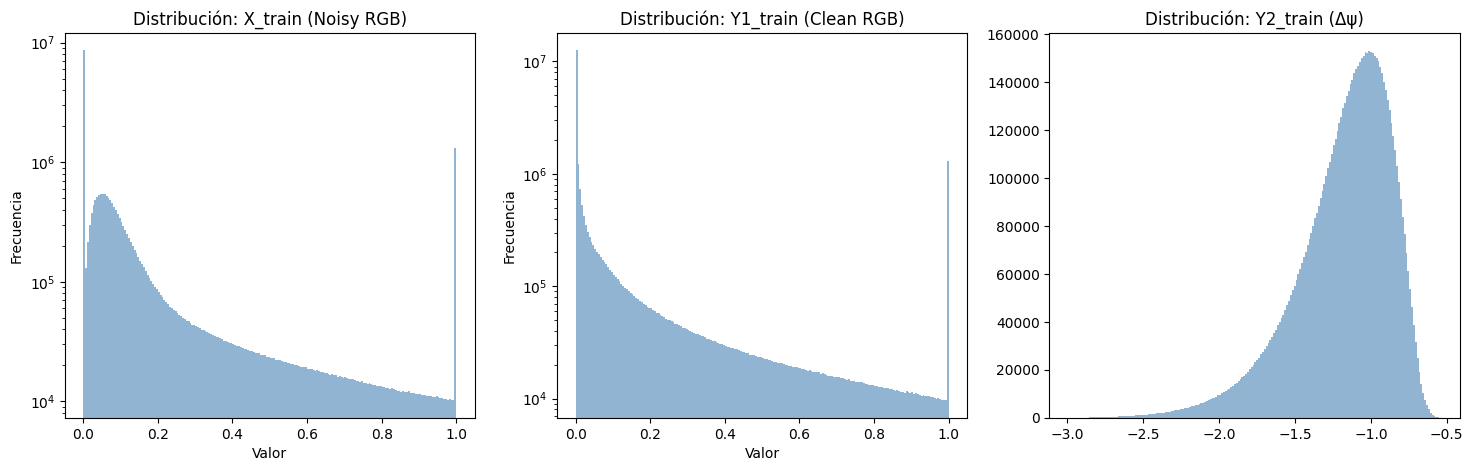

In [364]:
#Histograma de las variables
def plot_histogram(tensor, title, bins=200):
    t_np = tensor.cpu().numpy().flatten()
    plt.hist(t_np, bins=bins, alpha=0.6, color='steelblue')
    plt.title(title)
    plt.xlabel("Valor")
    plt.ylabel("Frecuencia")
    plt.grid(True)
    plt.show()

# plot_histogram(X_train, "Distribución: X_train (Noisy RGB)")
# plot_histogram(Y1_train, "Distribución: Y1_train (Clean RGB)")
# plot_histogram(Y2_train, "Distribución: Y2_train (Δψ)")

#Ponemos lo anterior en un subplot para los tres histogramas
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].hist(X_train.cpu().numpy().flatten(), bins=200, alpha=0.6, color='steelblue')
axes[0].set_title("Distribución: X_train (Noisy RGB)")
axes[0].set_xlabel("Valor")
#ponemos escala logarítmica en el eje y
axes[0].set_yscale('log')
axes[0].set_ylabel("Frecuencia")
axes[1].hist(Y1_train.cpu().numpy().flatten(), bins=200, alpha=0.6, color='steelblue')
axes[1].set_title("Distribución: Y1_train (Clean RGB)")
axes[1].set_yscale('log')
axes[1].set_xlabel("Valor")
axes[1].set_ylabel("Frecuencia")
axes[2].hist(Y2_train.cpu().numpy().flatten(), bins=200, alpha  = 0.6, color='steelblue')
axes[2].set_title("Distribución: Y2_train (Δψ)")                


In [365]:
mean_Y2 = Y2_train.mean().item()
std_Y2 = Y2_train.std().item()

Y2_train = (Y2_train - mean_Y2) / std_Y2
Y2_val   = (Y2_val   - mean_Y2) / std_Y2
Y2_test  = (Y2_test  - mean_Y2) / std_Y2

# --- Asegurar conversión a tensores ---
sub_mass_train = torch.tensor(sub_mass_train).float()
sub_mass_val   = torch.tensor(sub_mass_val).float()
sub_mass_test  = torch.tensor(sub_mass_test).float()

sub_x_train = torch.tensor(sub_x_train).float()
sub_x_val   = torch.tensor(sub_x_val).float()
sub_x_test  = torch.tensor(sub_x_test).float()


sub_y_train = torch.tensor(sub_y_train).float()
sub_y_val   = torch.tensor(sub_y_val).float()
sub_y_test  = torch.tensor(sub_y_test).float()

# --- Agrupar y normalizar ---
mxy_train = torch.stack([sub_mass_train, sub_x_train, sub_y_train], dim=1)
mxy_val   = torch.stack([sub_mass_val,   sub_x_val,   sub_y_val],   dim=1)
mxy_test  = torch.stack([sub_mass_test,  sub_x_test,  sub_y_test],  dim=1)

mean_mxy = mxy_train.mean(dim=0)
std_mxy  = mxy_train.std(dim=0)

mxy_train = (mxy_train - mean_mxy) / std_mxy
mxy_val   = (mxy_val   - mean_mxy) / std_mxy
mxy_test  = (mxy_test  - mean_mxy) / std_mxy


Text(0.5, 1.0, 'Distribución de coordenadas y')

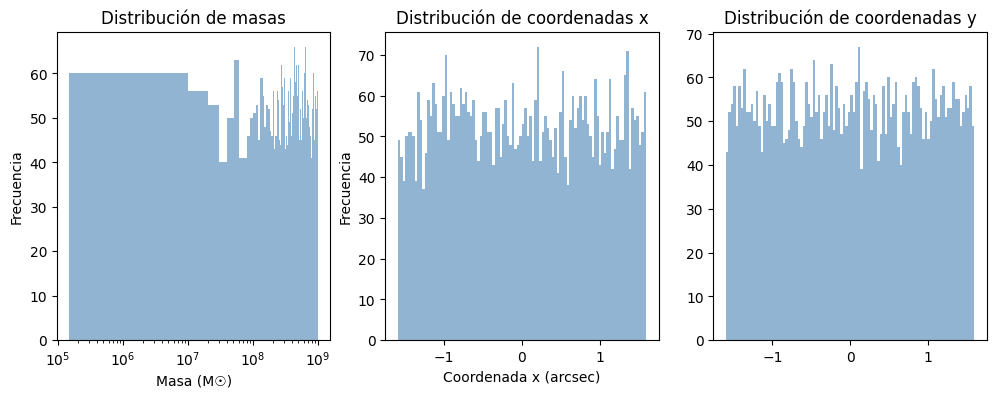

In [366]:
#Vamos a visualizar la distribución de las masas y coordenadas
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.hist(sub_mass_train.cpu().numpy(), bins=100, alpha=0.6, color='steelblue')
plt.title("Distribución de masas")
plt.xlabel("Masa (M☉)")
plt.xscale('log')
plt.ylabel("Frecuencia")
plt.subplot(1, 3, 2)
plt.hist(sub_x_train.cpu().numpy(), bins=100, alpha=0.6,    color='steelblue') 

#Ahora ponemos en un subplot m, x, y
plt.title("Distribución de coordenadas x")
plt.xlabel("Coordenada x (arcsec)")
plt.ylabel("Frecuencia")
plt.subplot(1, 3, 3)
plt.hist(sub_y_train.cpu().numpy(), bins=100, alpha=0.6, color='steelblue')
plt.title("Distribución de coordenadas y")          

In [367]:
# ✅ Estadísticas que sí necesitas guardar:
# 1. Para desnormalizar Y2 (Δψ map):

# Como estás usando z-score:
# mean_Y2 = Y2_train.mean().item()
# std_Y2 = Y2_train.std().item()

# 2. Para desnormalizar mxy (masa, x, y):
# mean_mxy = mxy_train.mean(dim=0)  # tensor([mean_mass, mean_x, mean_y])
# std_mxy = mxy_train.std(dim=0)    # tensor([std_mass, std_x, std_y])

norm_stats = {
    "mean_Y2": mean_Y2,
    "std_Y2": std_Y2,
    "mean_mass": mean_mxy[0].item(),
    "std_mass":  std_mxy[0].item(),
    "mean_x":    mean_mxy[1].item(),
    "std_x":     std_mxy[1].item(),
    "mean_y":    mean_mxy[2].item(),
    "std_y":     std_mxy[2].item()
}


In [368]:
from torch.utils.data import TensorDataset, DataLoader
import torch
#un batch más grande implica más memoria, pero puede ayudar a la estabilidad del entrenamiento
#uno mas chico implica más ruido en el gradiente, pero menos memoria

batch = 512  # Tamaño del batch
on_cuda = torch.cuda.is_available()

# 1) Datasets
train_ds = TensorDataset(X_train, Y1_train, Y2_train, mxy_train)
val_ds   = TensorDataset(X_val,   Y1_val,   Y2_val,   mxy_val)
test_ds  = TensorDataset(X_test,  Y1_test,  Y2_test,  mxy_test)

# 2) DataLoaders
common_kwargs = dict(
    batch_size=batch,
    num_workers=4,
    pin_memory=on_cuda,
    persistent_workers=True
)

train_loader = DataLoader(
    train_ds,
    shuffle=True,
    drop_last=True,
    **common_kwargs
)

val_loader = DataLoader(
    val_ds,
    shuffle=False,
    drop_last=False,
    **common_kwargs
)

test_loader = DataLoader(
    test_ds,
    shuffle=False,
    drop_last=False,
    **common_kwargs
)


In [369]:
g = torch.Generator()
g.manual_seed(42)
train_loader = DataLoader(train_ds, shuffle=True, generator=g, drop_last=True, **common_kwargs)

In [370]:
# Device
# 1) Detectar device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [371]:
class DualVAE(nn.Module):
    def __init__(self, in_ch=3, base_ch=16, z_dim=256, H=40, W=40):
        super().__init__()

        # ——— Encoder (3 convs stride=2) → (H/8, W/8) = (5,5) si H=W=40
        self.enc = nn.Sequential(
            nn.Conv2d(in_ch,     base_ch,   3, 2, 1), nn.ReLU(), nn.Dropout(0.1),
            nn.Conv2d(base_ch,   base_ch*2, 3, 2, 1), nn.ReLU(), nn.Dropout(0.1),
            nn.Conv2d(base_ch*2, base_ch*4, 3, 2, 1), nn.ReLU(), nn.Dropout(0.1),
        )

        # Tamaños tras las 3 convs (para 40→20→10→5)
        def conv_out(sz): return (sz + 2*1 - 3)//2 + 1
        H1, W1 = conv_out(H),    conv_out(W)   # 20
        H2, W2 = conv_out(H1),   conv_out(W1)  # 10
        H3, W3 = conv_out(H2),   conv_out(W2)  # 5

        self._C3 = 4 * base_ch
        self._H3 = H3
        self._W3 = W3
        feat_dim = self._C3 * H3 * W3

        # ——— VAE stats
        self.fc_mu     = nn.Linear(feat_dim, z_dim)
        self.fc_logvar = nn.Linear(feat_dim, z_dim)

        # ——— z → feature map
        self.fc_dec = nn.Linear(z_dim, feat_dim)

        # Decoder para imagen suave (RGB)
        self.decoder_s = nn.Sequential(
            nn.ReLU(),
            nn.Unflatten(1, (self._C3, self._H3, self._W3)),  # (N, 4*ch, 5, 5)
            nn.ConvTranspose2d(self._C3,   self._C3//2, 4, 2, 1),  # 5→10
            nn.ReLU(), nn.Dropout(0.1),
            nn.ConvTranspose2d(self._C3//2, base_ch,    4, 2, 1),  # 10→20
            nn.ReLU(), nn.Dropout(0.1),
            nn.ConvTranspose2d(base_ch,     3,          4, 2, 1),  # 20→40
            #nn.Sigmoid()
        )

        # Decoder para Δψ
        self.decoder_d = nn.Sequential(
            nn.ReLU(),
            nn.Unflatten(1, (self._C3, self._H3, self._W3)),  # (N, 4*ch, 5, 5)
            nn.ConvTranspose2d(self._C3,   self._C3//2, 4, 2, 1),  # 5→10
            nn.ReLU(), nn.Dropout(0.1),
            nn.ConvTranspose2d(self._C3//2, base_ch,    4, 2, 1),  # 10→20
            nn.ReLU(), nn.Dropout(0.1),
            nn.ConvTranspose2d(base_ch,     1,          4, 2, 1)   # 20→40
        )

        # ——— Cabezal de regresión (m, x, y) desde μ
        self.fc_regs = nn.Sequential(
            nn.Linear(z_dim, z_dim//2),
            nn.Tanh(), nn.Dropout(0.1),
            nn.Linear(z_dim//2, z_dim//2),
            nn.Tanh(), nn.Dropout(0.1),
            nn.Linear(z_dim//2, 3)
        )

    def encode(self, x):
        h = self.enc(x)
        h = h.view(h.size(0), -1)
        mu, logvar = self.fc_mu(h), self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = (0.5 * logvar).exp()
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_dec(z)
        s = self.decoder_s(h)  # (N, 3, 40, 40)
        d = self.decoder_d(h)  # (N, 1, 40, 40)
        return s, d

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        s, d = self.decode(z)
        mxy_pred = self.fc_regs(mu)  # (N, 3)
        return s, d, mu, logvar, mxy_pred


In [372]:
model = DualVAE(in_ch=3, base_ch=20, z_dim=256, H=40, W=40).to(device)


In [373]:
# 3.3) Optimizer (puede quedarse igual)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.001,  # learning rate
    weight_decay=1e-4  # L2 regularization (decay)
)

In [374]:
##### otra versión del costo ######
def combined_loss(s_pred, s_true,
                  d_pred, d_true,
                  mu, logvar,
                  mxy_pred, mxy_true,
                  alpha=1.0, beta=1e-3, gamma=1.0):
    """
    Combined loss for multitask VAE.
    """
    # Reconstruction loss (RGB + alpha * Δψ)
    recon_rgb = F.mse_loss(s_pred, s_true)
    recon_d   = F.mse_loss(d_pred, d_true)
    recon = recon_rgb + alpha * recon_d

    # KL divergence (average over batch * z_dim)
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    # Regression loss
    reg = F.mse_loss(mxy_pred, mxy_true)

    # Final loss
    total = recon + beta * kl + gamma * reg

    return total


In [375]:
def train_epoch(loader, optimizer, alpha=1.0, beta=1e-3, gamma=1.0, log_batches=2):
    model.train()
    running_loss = 0.0

    for i, (x, y_s, y_d, mxy) in enumerate(loader):
        x   = x.to(device, non_blocking=True)
        y_s = y_s.to(device, non_blocking=True)
        y_d = y_d.to(device, non_blocking=True)
        mxy = mxy.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        # ❌ sin autocast
        p_s, p_d, mu, logvar, mxy_pred = model(x)

        recon_s = F.mse_loss(p_s, y_s)
        recon_d = F.mse_loss(p_d, y_d)
        kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        reg = F.mse_loss(mxy_pred, mxy)

        loss = recon_s + alpha * recon_d + beta * kl + gamma * reg

        # ❌ sin scaler
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item() * x.size(0)

        if i < log_batches:
            print(f"[Batch {i}] Loss: {loss.item():.4f} | Recon_s: {recon_s.item():.4f} | "
                  f"Recon_d: {recon_d.item():.4f} | KL: {kl.item():.4f} | Reg: {reg.item():.4f}")

    return running_loss / len(loader.dataset)


def eval_epoch(loader, alpha=1.0, beta=1e-3, gamma=1.0):
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for x, y_s, y_d, mxy in loader:
            x   = x.to(device, non_blocking=True)
            y_s = y_s.to(device, non_blocking=True)
            y_d = y_d.to(device, non_blocking=True)
            mxy = mxy.to(device, non_blocking=True)

            # ❌ sin autocast
            p_s, p_d, mu, logvar, mxy_pred = model(x)

            loss = combined_loss(p_s, y_s, p_d, y_d, mu, logvar, mxy_pred, mxy,
                                 alpha, beta, gamma)

            running_loss += loss.item() * x.size(0)

    return running_loss / len(loader.dataset)


In [376]:
# Training loop
num_epochs = 200
alpha = 1.0 # peso de la reconstrucción de la imagen suave 
beta  = 1e-3 # peso de la divergencia KL
gamma = 1.0 # peso de la regresión de masa y coordenadas

train_losses = []
val_losses   = []

outer_bar = trange(5, num_epochs + 1, desc="Epoch", ncols=120, colour="#37BBCC", dynamic_ncols=False)

for epoch in outer_bar:
    train_loss = train_epoch(train_loader, optimizer, alpha, beta, gamma, log_batches=0)  # 👈 no imprimir batches
    val_loss   = eval_epoch(val_loader, alpha, beta, gamma)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    outer_bar.set_postfix(train=f"{train_loss:.4f}", val=f"{val_loss:.4f}")


Epoch: 100%|████████████████████████████████████████████████| 196/196 [01:37<00:00,  2.00it/s, train=1.4541, val=1.4038]


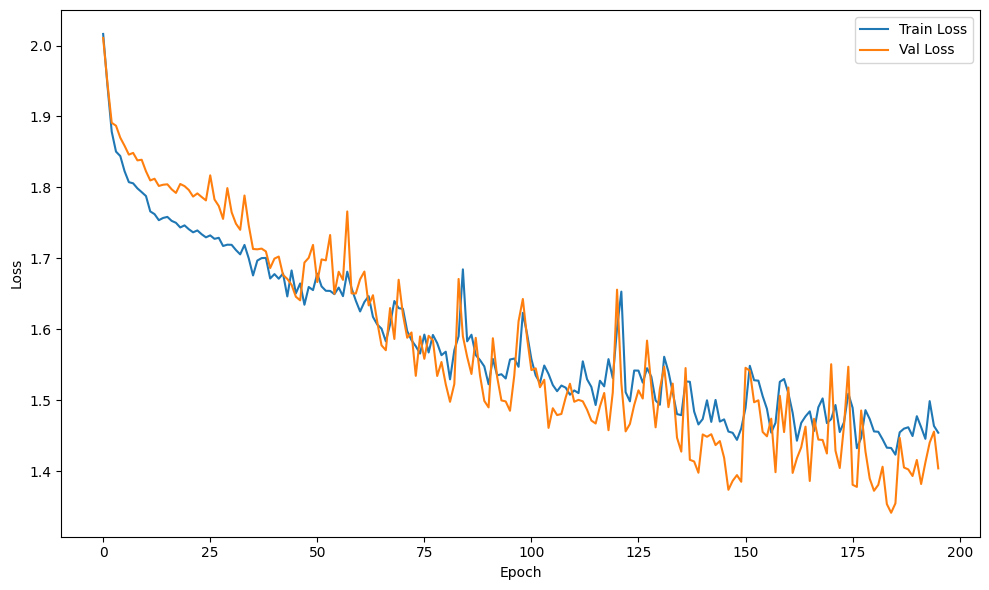

In [377]:
plt.figure(figsize=(10,6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses,   label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
#plt.yscale('log')
plt.legend(); plt.tight_layout(); plt.show()


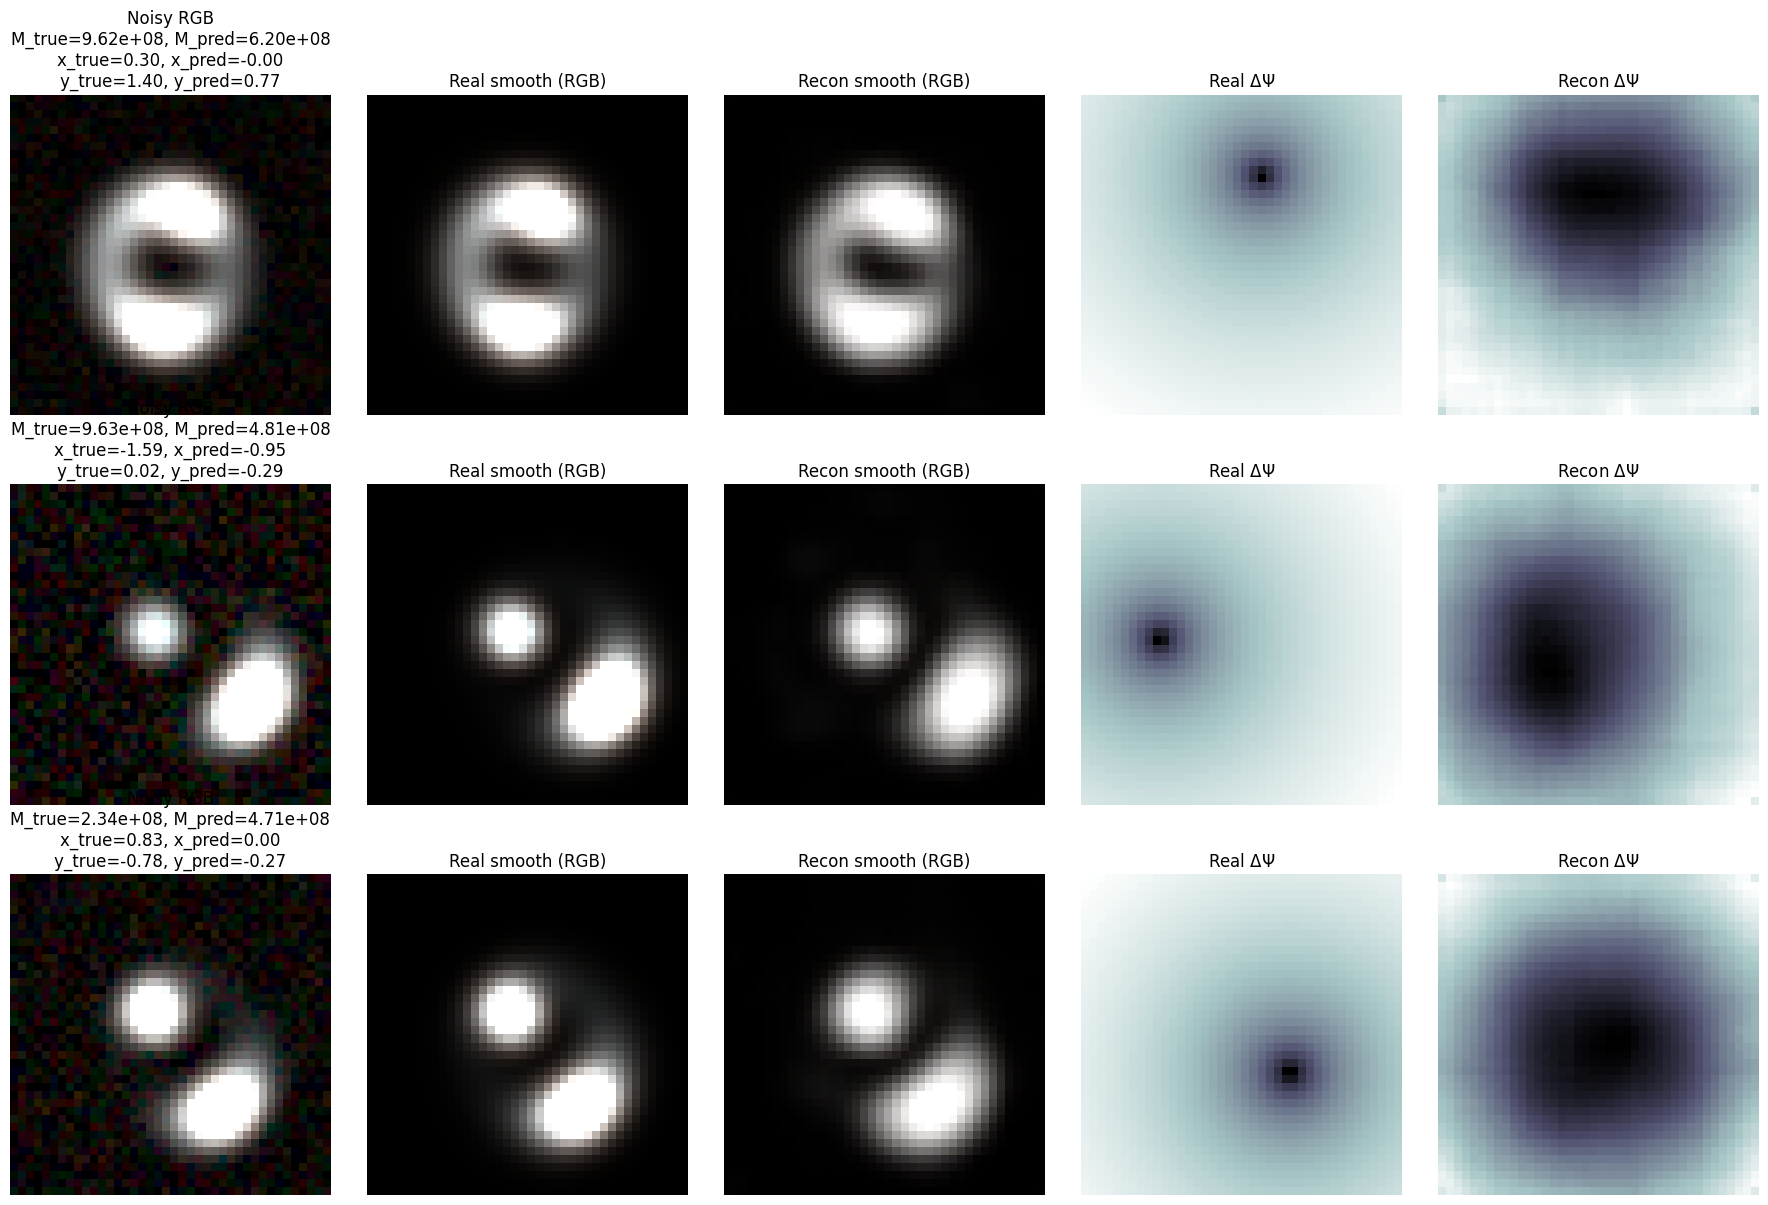

In [378]:
# === Paso 1: Forward pass y conversión a NumPy ===
model.eval()
with torch.no_grad():
    x, y_true_smooth, y_true_delta, mxy_true = next(iter(test_loader))
    x, y_true_smooth, y_true_delta, mxy_true = (
        x.to(device),
        y_true_smooth.to(device),
        y_true_delta.to(device),
        mxy_true.to(device),
    )
    y_pred_smooth, y_pred_delta, mu, logvar, mxy_pred = model(x)

# Convertir a NumPy (todo en CPU)
x_np         = x.detach().cpu().numpy()
y_true_s_np  = y_true_smooth.detach().cpu().numpy()
y_true_d_np  = y_true_delta.detach().cpu().numpy()
y_pred_s_np  = y_pred_smooth.detach().cpu().numpy()
y_pred_d_np  = y_pred_delta.detach().cpu().numpy()
mxy_true_np  = mxy_true.detach().cpu().numpy()
mxy_pred_np  = mxy_pred.detach().cpu().numpy()

# === Paso 2: Desnormalización ===
mean_Y2 = norm_stats["mean_Y2"]
std_Y2  = norm_stats["std_Y2"]

mean_mxy = np.array([norm_stats["mean_mass"], norm_stats["mean_x"], norm_stats["mean_y"]])
std_mxy  = np.array([norm_stats["std_mass"],  norm_stats["std_x"],  norm_stats["std_y"]])

# Desnormalizar predicciones y ground truth
mxy_pred_np_denorm = mxy_pred_np * std_mxy + mean_mxy
mxy_true_np_denorm = mxy_true_np * std_mxy + mean_mxy
y_pred_d_np_denorm = y_pred_d_np * std_Y2 + mean_Y2
y_true_d_np_denorm = y_true_d_np * std_Y2 + mean_Y2

# === Paso 3: Visualización ===
offset    = 0
max_rows  = 3
N         = x_np.shape[0]
n_samples = max(1, min(max_rows, N - offset))

fig, axes = plt.subplots(n_samples, 5, figsize=(18, 4 * n_samples))
if n_samples == 1:
    axes = np.array(axes).reshape(1, 5)

for i in range(n_samples):
    idx = i + offset

    # Valores de regresión desnormalizados
    m_true, x_true, y_true = mxy_true_np_denorm[idx]
    m_pred, x_pred, y_pred = mxy_pred_np_denorm[idx]

    # Col 0: Entrada ruidosa
    ax = axes[i, 0]
    ax.imshow(np.clip(x_np[idx].transpose(1, 2, 0), 0, 1))
    ax.set_title(
        f"Noisy RGB\n"
        f"M_true={m_true:.2e}, M_pred={m_pred:.2e}\n"
        f"x_true={x_true:.2f}, x_pred={x_pred:.2f}\n"
        f"y_true={y_true:.2f}, y_pred={y_pred:.2f}"
    )
    ax.axis('off')

    # Col 1: Smooth real (RGB)
    ax = axes[i, 1]
    ax.imshow(np.clip(y_true_s_np[idx].transpose(1, 2, 0), 0, 1))
    ax.set_title("Real smooth (RGB)")
    ax.axis('off')

    # Col 2: Smooth recon (RGB)
    ax = axes[i, 2]
    ax.imshow(np.clip(y_pred_s_np[idx].transpose(1, 2, 0), 0, 1))
    ax.set_title("Recon smooth (RGB)")
    ax.axis('off')

    # Col 3: Δψ real
    ax = axes[i, 3]
    ax.imshow(y_true_d_np_denorm[idx, 0], origin='lower', cmap='bone')
    ax.set_title(r"Real $\Delta\Psi$")
    ax.axis('off')

    # Col 4: Δψ recon
    ax = axes[i, 4]
    ax.imshow(y_pred_d_np_denorm[idx, 0], origin='lower', cmap='bone')
    ax.set_title(r"Recon $\Delta\Psi$")
    ax.axis('off')

plt.tight_layout()
plt.show()


MASS  MSE=6.4604e+16, MAE=2.1708e+08,  R²=0.2474
XPOS  MSE=5.9717e-01, MAE=6.4474e-01,  R²=0.2289
YPOS  MSE=6.8443e-01, MAE=6.9096e-01,  R²=0.1799


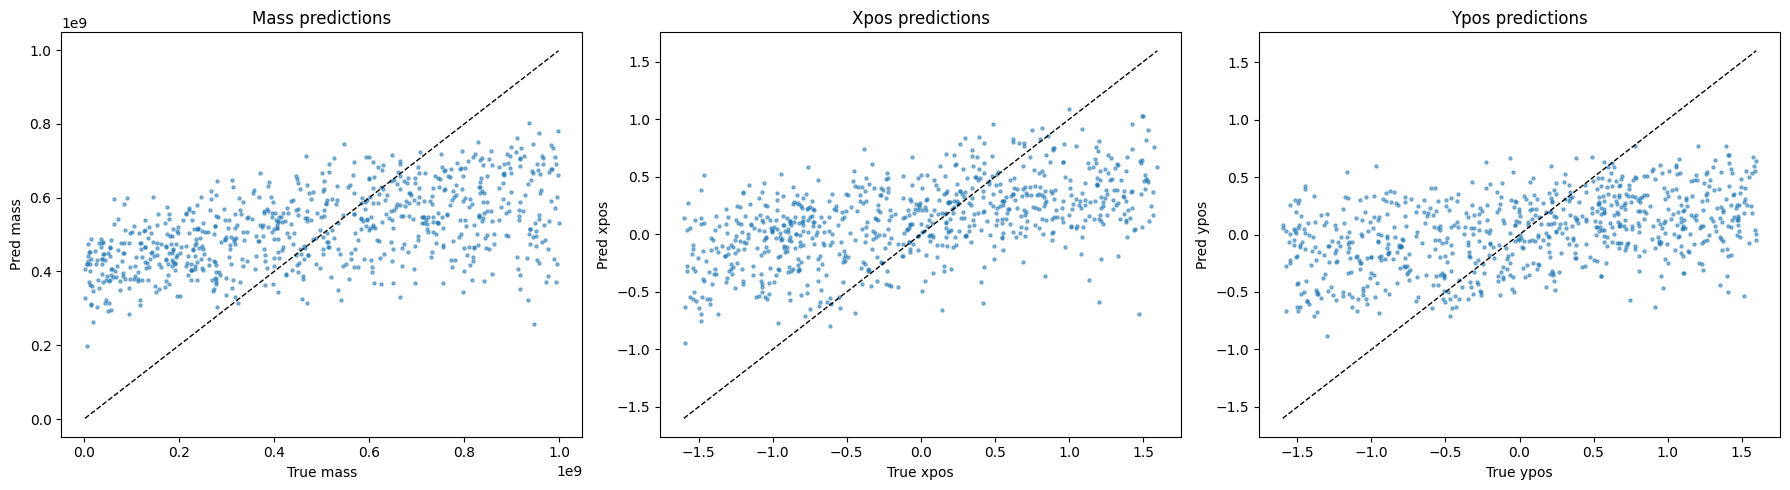

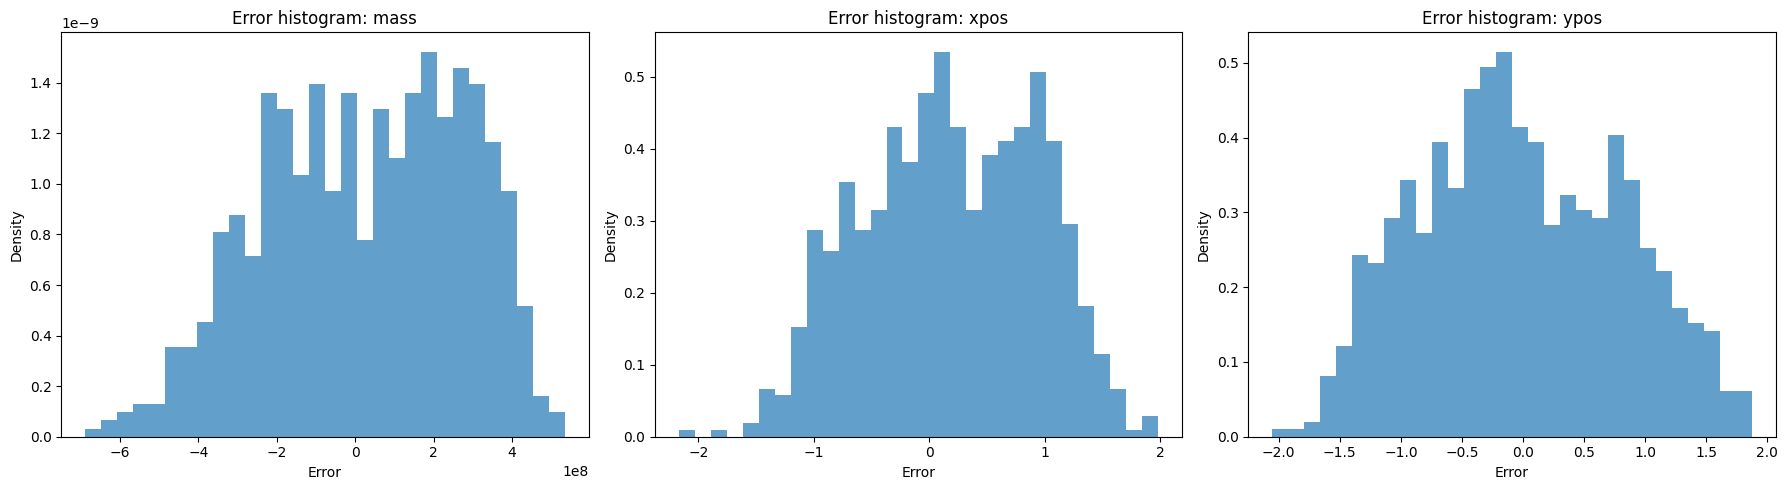

In [379]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1) Extrae medias y stds para desnormalizar
mean_mxy = np.array([
    norm_stats["mean_mass"],
    norm_stats["mean_x"],
    norm_stats["mean_y"]
])
std_mxy = np.array([
    norm_stats["std_mass"],
    norm_stats["std_x"],
    norm_stats["std_y"]
])

# 2) Eval loop
model.eval()
all_pred = []
all_true = []

with torch.no_grad():
    for x, y_s, y_d, mxy_true in test_loader:
        x = x.to(device)
        _, _, _, _, mxy_pred = model(x)
        all_pred.append(mxy_pred.cpu().numpy())
        all_true.append(mxy_true.numpy())

# 3) Concatenar resultados
all_pred = np.vstack(all_pred)  # shape (N, 3)
all_true = np.vstack(all_true)

# 4) Desnormalizar
all_pred = all_pred * std_mxy + mean_mxy
all_true = all_true * std_mxy + mean_mxy

# 5) Métricas por variable
names = ['mass', 'xpos', 'ypos']
for i, name in enumerate(names):
    y_t = all_true[:, i]
    y_p = all_pred[:, i]
    mse = mean_squared_error(y_t, y_p)
    mae = mean_absolute_error(y_t, y_p)
    r2  = r2_score(y_t, y_p)
    print(f"{name.upper():>4}  MSE={mse:.4e}, MAE={mae:.4e},  R²={r2:.4f}")

# 6) Scatter plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, name in enumerate(names):
    axes[i].scatter(all_true[:, i], all_pred[:, i], s=5, alpha=0.5)
    min_val = min(all_true[:, i].min(), all_pred[:, i].min())
    max_val = max(all_true[:, i].max(), all_pred[:, i].max())
    axes[i].plot([min_val, max_val], [min_val, max_val], 'k--', lw=1)
    axes[i].set_xlabel(f"True {name}")
    axes[i].set_ylabel(f"Pred {name}")
    axes[i].set_title(f"{name.title()} predictions")
plt.tight_layout()
plt.show()

# 7) Histogramas de error
errors = all_pred - all_true
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, name in enumerate(names):
    axes[i].hist(errors[:, i], bins=30, density=True, alpha=0.7)
    axes[i].set_title(f"Error histogram: {name}")
    axes[i].set_xlabel("Error")
    axes[i].set_ylabel("Density")
plt.tight_layout()
plt.show()
